# The Code Section

In [1]:
from qiskit import *
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
import  qiskit.circuit.library.grover_operator
from qiskit.circuit.library import *
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.utils import QuantumInstance
import math
from cmath import rect
from math import pi
from collections import defaultdict
from dwave.system import DWaveSampler, EmbeddingComposite,LeapHybridSampler
import random
from functools import reduce
from operator import mul
from scipy.linalg import *
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
def runBackend(qc,backend,mntr=True):
    qobj = transpile(qc,backend)
    job = backend.run(qobj)
    if mntr:
        job_monitor(job)
    return job.result().get_counts()
def runAer(qc):
    return runBackend(qc,Aer.get_backend('aer_simulator'),False)
def runReal(qc,n):
    provider = IBMQ.get_provider('ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >=n and x.name()!='ibmq_bogota'  and 
                                        not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    return runBackend(qc,backend)

In [4]:
# Deutch-Jozsa Problem

A combination of X and CX gates form a balance function. A sequence of these gates can be used for generating a quantum oracle for the balanced function. Having no such sequence implies that the function being constructed is constant. invertY=True inverts the 2nd register, effectively inverting the output for every state.

In [5]:
# 0 for identity, 1 for cx, 2 for X CX X
# initialize y qbit with + or - state
def create_oracle(oracleStr,invertY):
    n = len(oracleStr)
    f = QuantumCircuit(n+1)
    flippers = QuantumCircuit(n+1)
    oracle = QuantumCircuit(n+1)
    if invertY:
        oracle.x(n)
    for qbit in range(n):
        if int(oracleStr[qbit])>0:
            f.cx(qbit,n)
        if int(oracleStr[qbit])>1:
            flippers.x(qbit)
    f.barrier()
    flippers.barrier()
    return oracle.compose(flippers).compose(f).compose(flippers)

The function below puts together the initialization, the oracle and
and measurement

In [6]:
def create_dj(oracleStr,invertY):
    n = len(oracleStr)
    dj = QuantumCircuit(n+1,n)
    for qbit in range(n):
        dj.h(qbit)
    dj.x(n)
    dj.h(n)
    dj.barrier()
    dj.compose(create_oracle(oracleStr,invertY),inplace=True)

    for qbit in range(n):
        dj.h(qbit)
    dj.barrier()
    dj.measure(range(n),range(n))
    return dj

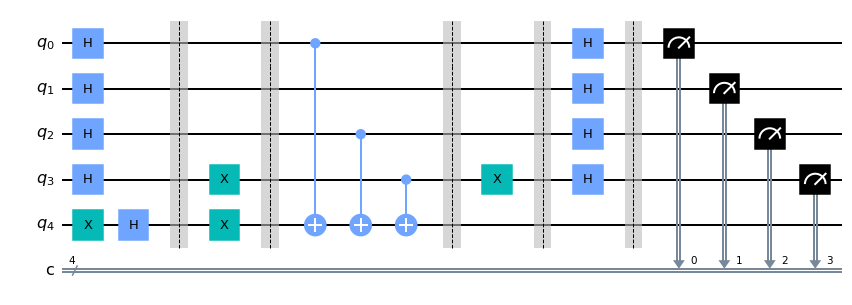

In [7]:
s = '1012'
invY=True
dj = create_dj(s,invY)
n=len(s)
dj.draw('mpl')

The X axis of every measurement graph represents the individual states.

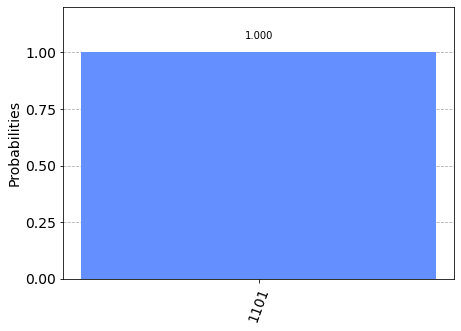

In [8]:
plot_histogram(runAer(dj))

least busy backend:  ibmq_lima
Job Status: job has successfully run


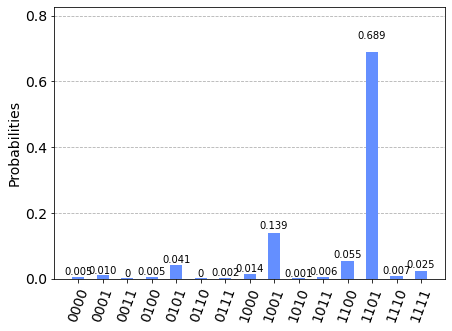

In [9]:
plot_histogram(runReal(dj,n+1))

It can be noted that the 1101 state for both the real and the simulator has the maximum amplitude.

# Bloch Spheres

The following code shows the Bloch plot for few of the states.
$$ |q\rangle = cos \frac{\theta}{2} |0\rangle + e^{i~\phi} sin\frac{\theta}{2}|1\rangle $$
The global state of a qbit is not represented in Bloch shpere

$$|1\rangle = e^{i~0}sin\frac{\pi}{2}|1\rangle$$

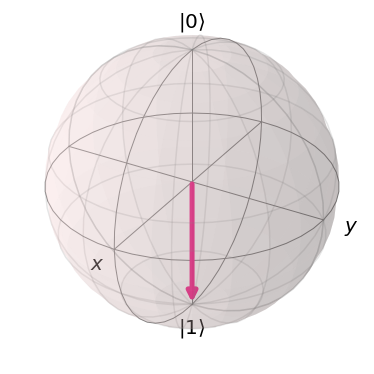

In [10]:
plot_bloch_vector([1,pi,0],coord_type="spherical")

$$|1\rangle = e^{i~\pi/2}sin\frac{\pi}{2}|1\rangle$$

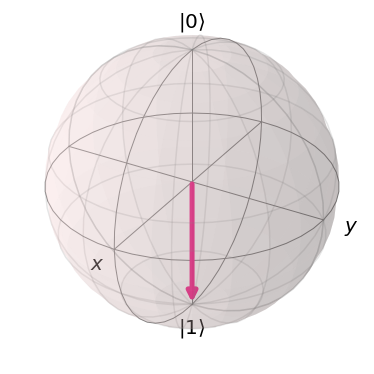

In [11]:
plot_bloch_vector([1,pi,pi/2],coord_type="spherical")

$$|+\rangle = cos\frac{\pi}{4}|0\rangle+e^{i~0}sin\frac{\pi}{4}|1\rangle$$

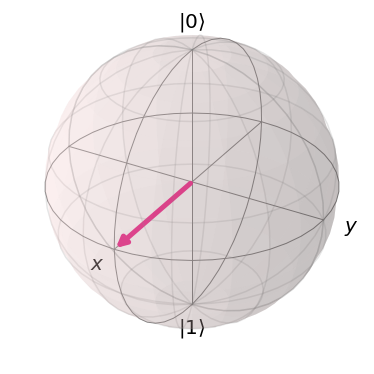

In [12]:
plot_bloch_vector([1,pi/2,0],coord_type="spherical")

$$|-\rangle = cos\frac{\pi}{4}|0\rangle+e^{i~\pi}sin\frac{\pi}{4}|1\rangle$$

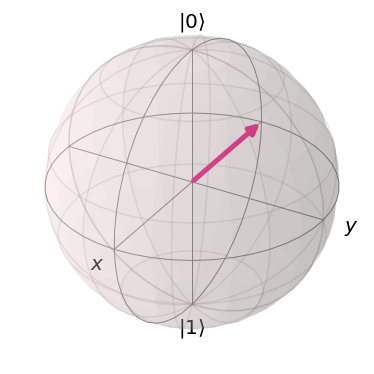

In [13]:
# Hadamard + with a phase difference of pi
plot_bloch_vector([1,pi/2,pi],coord_type="spherical")

$$|i\rangle = cos\frac{\pi}{4}|0\rangle+e^{i~\pi/2}sin\frac{\pi}{4}|1\rangle$$

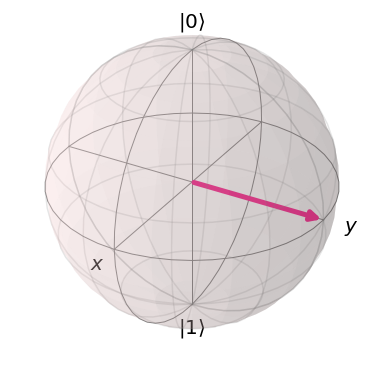

In [14]:
plot_bloch_vector([1,pi/2,pi/2],coord_type="spherical")

$$|-i\rangle = cos\frac{\pi}{4}|0\rangle+e^{-i~\pi/2}sin\frac{\pi}{4}|1\rangle$$

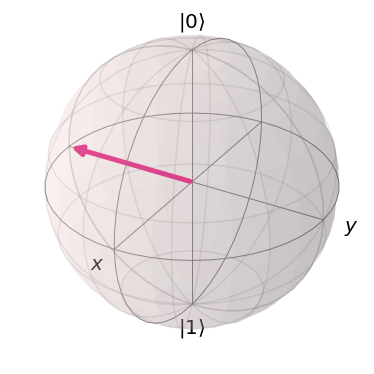

In [15]:
plot_bloch_vector([1,pi/2,-pi/2],coord_type="spherical")

# Quantum Entanglement

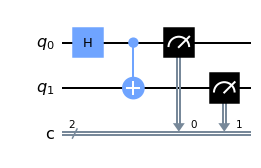

In [16]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])
qc.draw('mpl')

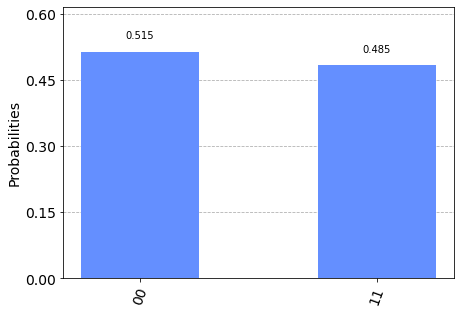

In [17]:
plot_histogram(runAer(qc))

# Phase Kickback

The qc2 circuit is the full circuit. The qc1 circuit does not have the last CX gate for showing the phase kickback phenomenon.

In [18]:
sim = Aer.get_backend('aer_simulator')

In [19]:
qc1 = QuantumCircuit(2)
qc1.x(1)
qc1.h((0,1))
qc1.save_statevector()
s1=sim.run(assemble(qc1)).result().get_statevector()

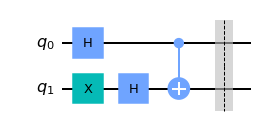

In [20]:
qc2 = QuantumCircuit(2)
qc2.x(1)
qc2.h((0,1))
qc2.cx(0,1)
qc2.save_statevector()
s2=sim.run(assemble(qc2)).result().get_statevector()
qc2.draw('mpl')

The state's phase till before cx gate is $|-+\rangle$. The phase of the control qbit changes due to phase kickback to $|--\rangle$

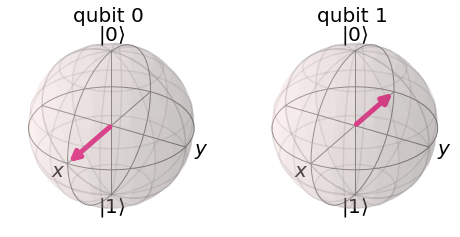

In [21]:
plot_bloch_multivector(s1)

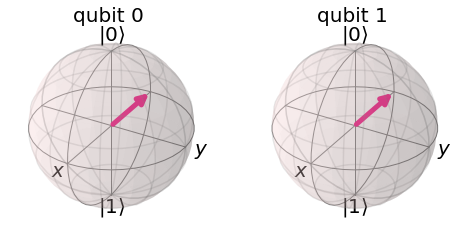

In [22]:
plot_bloch_multivector(s2)

# Quantum Teleportation

Quantum Teleportation is a way of sending qbit state from one place to another by using classical bits and Quantum Entanglement.

In [23]:
sim = Aer.get_backend('aer_simulator')

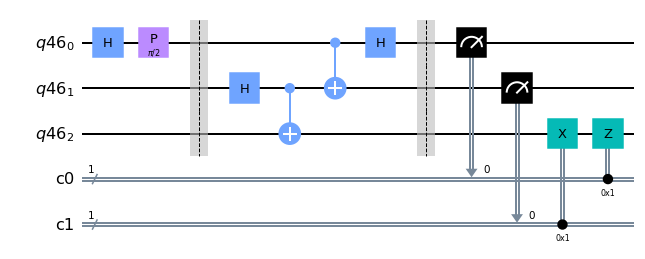

In [24]:
qc = QuantumCircuit(QuantumRegister(3),ClassicalRegister(1),ClassicalRegister(1))
qc.h(0)
qc.p(math.pi/2,0)
qc.barrier()
qc.h(1)
qc.cx(1,2)
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure([0,1],[0,1])
qc.x(2).c_if(qc.cregs[1],1)
qc.z(2).c_if(qc.cregs[0],1)
qc.draw('mpl')

The expected state vector is shown in the plot below. The qbit 2 should have this state if the teleportation succeded.

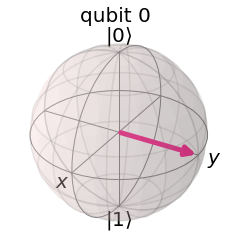

In [25]:
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.p(math.pi/2,0)
qc1.save_statevector()
s1=execute(qc1,sim,shots=1024).result().get_statevector()
plot_bloch_multivector(s1,figsize=(1.5,1.5))

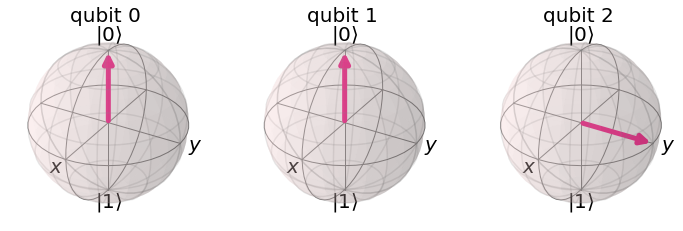

In [26]:
qc.save_statevector()
s=execute(qc,sim,shots=1024).result().get_statevector()
plot_bloch_multivector(s,figsize=(1.5,1.5))

# Bernstien-Vazirani Problem

Given a function $f(x)=s.x~(mod~2)$ which takes a string of bits to either 0 or 1, find s. The mathematical explanation of the circuit is given below.
$$|0\rangle \rightarrow^{H^{\otimes n}}\frac{1}{\sqrt{2^n}}\sum_{x \in \{ 0,1 \}^n}^{}{(-1)^{0.x}|x\rangle}=\frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \}^n}^{}{|x\rangle}$$ $$\rightarrow^{f_s} \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \}^n}^{}{(-1)^{f_s(x).x}|x\rangle}= \frac{1}{\sqrt{2^n}}\sum_{x \in \{ 0,1 \}^n}^{}{(-1)^{s.x}|x\rangle}\rightarrow^{H^{\otimes n}} |s\rangle$$

In [27]:
def circuitBV(s):
    s = s[::-1]
    n = len(s)
    qc = QuantumCircuit(QuantumRegister(n),QuantumRegister(1),ClassicalRegister(n))
    for i in range(n):
        qc.h(i)
    qc.h(n)
    qc.z(n)
    qc.barrier()
    for i in range(n):
        if s[i]=='1':
            qc.cx(i,n)
    qc.barrier()
    for i in range(n):
        qc.h(i)
    qc.measure(range(n),range(n))
    return qc

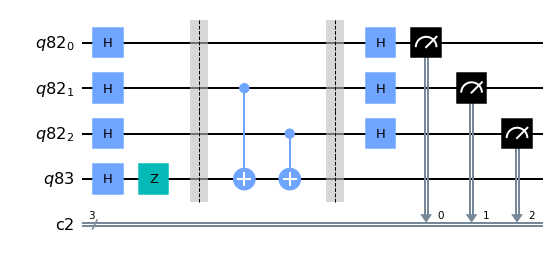

In [28]:
# s is the binary string to find as string type
s = "110"
n = len(s)
qc = circuitBV(s)
qc.draw('mpl')

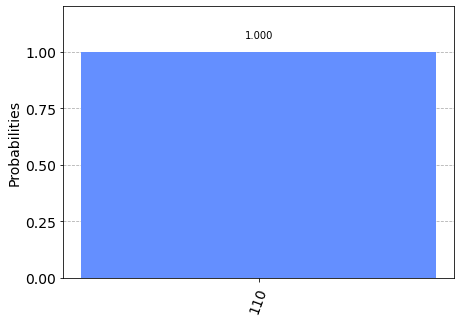

In [29]:
plot_histogram(runAer(qc))

least busy backend:  ibmq_lima
Job Status: job has successfully run


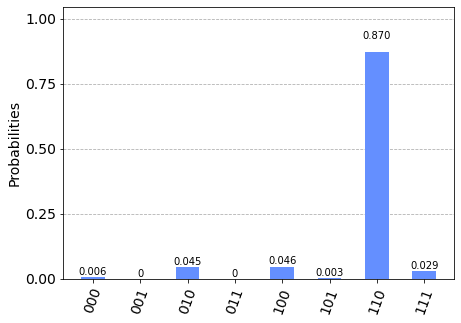

In [30]:
plot_histogram(runReal(qc,n))

# Grover's Algorithm

In [31]:
sim = Aer.get_backend('qasm_simulator')

The number of iterations to run in a Grover's algorithm is roughly $\sqrt{n}$ where n is the number of qbits. Running $H \otimes Oracle \otimes H \otimes Reflector \otimes H$ is one iteration. With increase in number of states to search for, the accuracy also drops with it.

In [32]:
n = 3
N = 2**n
rn = range(n)

The oracle here has CZ gate at (0,1) and (1,2). Due to this, the phase of 110 and 011 states will be $\pi$. But the phase of state 111 will be $2\pi$ which is effectively 0.

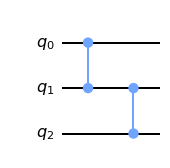

In [33]:
o = QuantumCircuit(n,name='oracle')
o.cz(range(n-1),range(1,n))
o.to_gate()
o.draw('mpl')

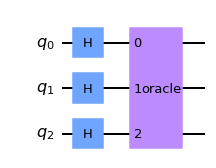

In [34]:
gc = QuantumCircuit(n)
gc.h(rn)
gc.append(o,rn)
gc.draw('mpl')

The Inverter ( or the reflector) gate is constructed directly using its matrix representation.

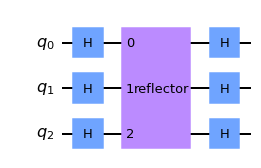

In [35]:
ref = QuantumCircuit(n,name='reflection')
mop = np.identity(N)*-1
mop[0][0]=1
op = qi.Operator(mop)
ref.h(rn)
ref.unitary(op,rn,label='reflector')
ref.h(rn)
ref.draw('mpl')

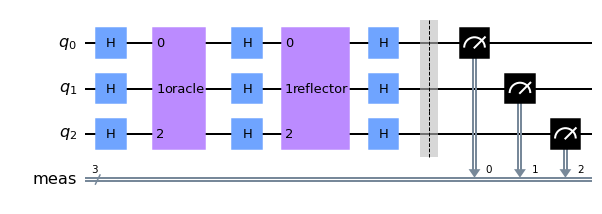

In [36]:
gc.compose(ref,inplace=True)
gc.measure_all()
gc.draw('mpl')

As expected, the algorithm found the correct solutions.

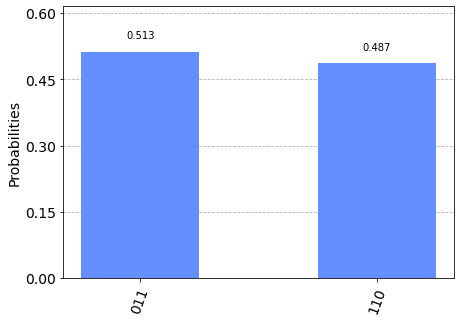

In [37]:
plot_histogram(runAer(gc))

# Quantum Fourier Transform

This notebook runs Quantum Fourier Transform for $|0000\rangle$ input in both the simulator and a real quantum computer.

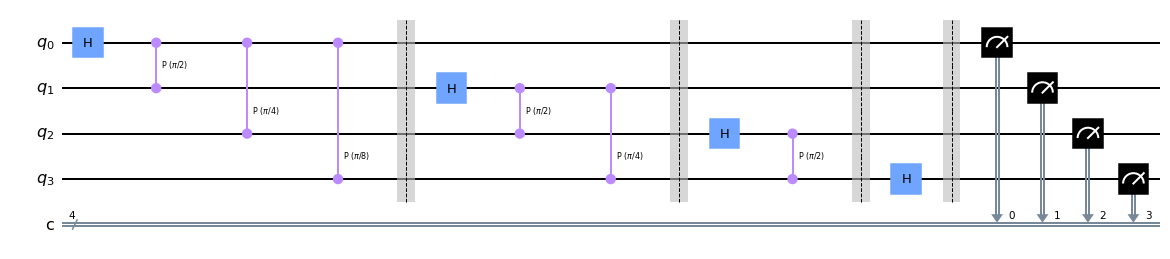

In [38]:
n=4
N=2**n
qc = QuantumCircuit(n,n)
for q in range(n):
    qc.h(q)
    for k in range(q+1,n):
        qc.cp(np.pi/(2**(k-q)),k,q)
    qc.barrier()
mes=range(n)
qc.measure(mes,mes)
qc.draw('mpl')

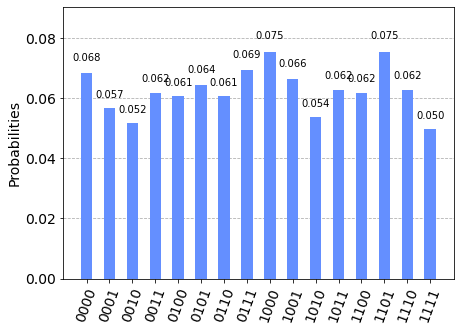

In [39]:
plot_histogram(runAer(qc))

least busy backend:  ibmq_lima
Job Status: job has successfully run


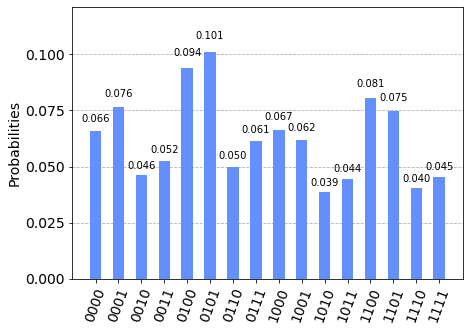

In [40]:
plot_histogram(runReal(qc,n))

# Quantum Phase Estimation

In [41]:
def inverse_qft(qc, n):
    for q in range(n//2):
        qc.swap(q, n-q-1)
    for q in range(n):
        for k in range(q+1,n):
            qc.cp(-math.pi/(2**(k-q)),k,q)
        qc.h(q)
        qc.barrier()

In [42]:
def qpe_e(n,theta):
    rn = list(range(n))
    qc=QuantumCircuit(n+1,n)
    qc.x(n)
    qc.h(rn)
    for i in rn:
        for j in range(2**i):
            qc.cp(theta,i,n)
    qc.barrier()
    inverse_qft(qc,n)
    qc.measure(rn,rn)
    return qc

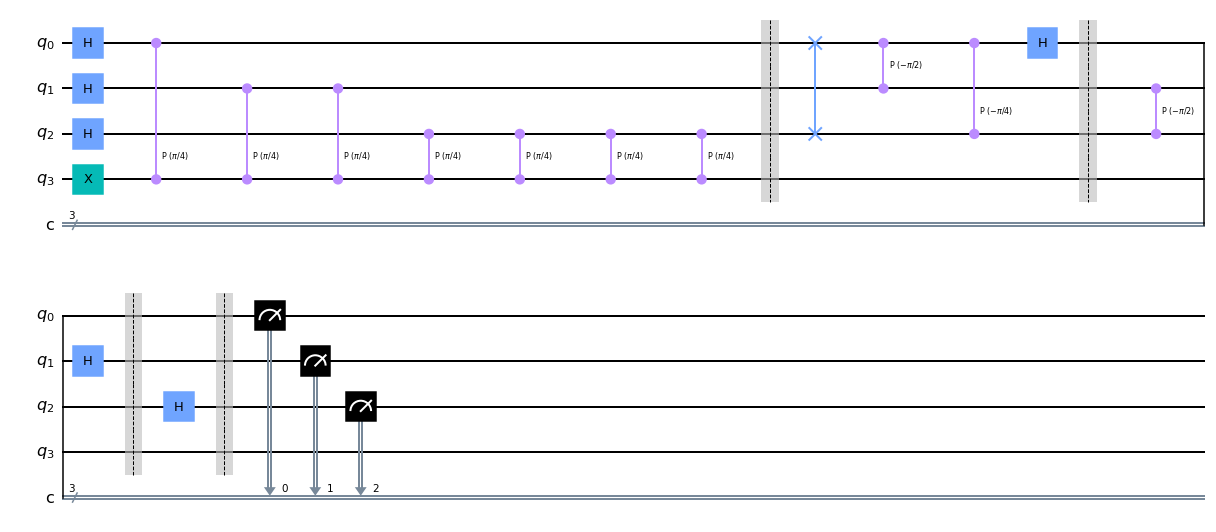

In [43]:
n=3
theta =  1/ 4
q=qpe_e(n,math.pi*theta)
cnt=runAer(q) # Fine the state with most counts and put it in m
m=max(cnt, key= lambda x: cnt[x]) # Simulated QPE and its computation of theta
t1=int(m,2)/2**(n-1)
q.draw('mpl')

In [44]:
m=max(runReal(q,n), key= lambda x: cnt[x])
t2=int(m,2)/2**(n-1)
print('Theta \n\n','Original ',theta,'\n Simulation ',t1,'\nReal Hardware : ',t2)

least busy backend:  ibmq_lima
Job Status: job has successfully run
Theta 

 Original  0.25 
 Simulation  0.25 
Real Hardware :  0.25


# Shor's Algorithm

Implementation of the N=15 a=13 case of Shor's algorithm

In [45]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [46]:
def shors(a,n):
    qc = QuantumCircuit(4+n, n)
    rn = range(n)
    rin = [i+n for i in range(4)]
    for q in range(n):
        qc.h(q)
    qc.x(3+n)
    for q in range(n):
        qc.append(c_amod15(a, 2**q),[q]+rin)
    qc.append(QFT(n,2,inverse=True),rn)
    qc.measure(rn,rn)
    return runAer(qc)

In [47]:
N = 15
a = 7
counts = shors( a, n = 10)
print(counts)
while len(counts)!=0:
    s=counts.popitem()
    r=int(s[0],2)
    if r%2==1:
        continue
    t = int(a**(int(r)/2))
    if t==1:
        continue
    p = math.gcd(t-1,N)
    q = math.gcd(t+1,N)
    if p==1 and q==1:
        continue
    if p==1:
        if q != N:
            print('p = ',p,'   q = ',N//q)
            break
    elif q ==1:
        if p != N:
            print('p = ',p,'   q = ',N//p)
            break
    else:
        print('p = ',p,'   q = ',q)
        break
    print('p = ',p,'   q = ',q)

{'0100000000': 244, '0000000000': 247, '1100000000': 274, '1000000000': 259}
p =  1    q =  5


# Sudoku 2x2

The 2x2 Sudoku is implemented in 2 different ways. One is the usual circuit construction, the other is using the PhaseOracle.

In [48]:
# Constraints for 2x2 sudoku
cnst = [(0,1),(0,2),(1,3),(2,3)]

In [49]:
def sud2x2():
    var = QuantumRegister(4,"var")
    wrk = QuantumRegister(4,"wrk")
    out = QuantumRegister(1,"out")
    mes = ClassicalRegister(4,"mes")
    qc = QuantumCircuit(var,wrk,out,mes)
    qc.h(var)
    qc.x(out)
    qc.h(out)
    mt = -1*np.identity(16)
    mt[0][0]=1
    op = qi.Operator(mt)
    for qwre in range(2):
        i=0
        for x in cnst:
            qc.cx(var[x[0]],wrk[i])
            qc.cx(var[x[1]],wrk[i])
            i+=1
        qc.mct(wrk,out)
        i=0
        for x in cnst:
            qc.cx(var[x[0]],wrk[i])
            qc.cx(var[x[1]],wrk[i])
            i+=1
        qc.barrier()
        qc.h(var)
        qc.append(op,var)
        qc.h(var)
        qc.barrier()
    qc.measure(var,mes)
    return qc


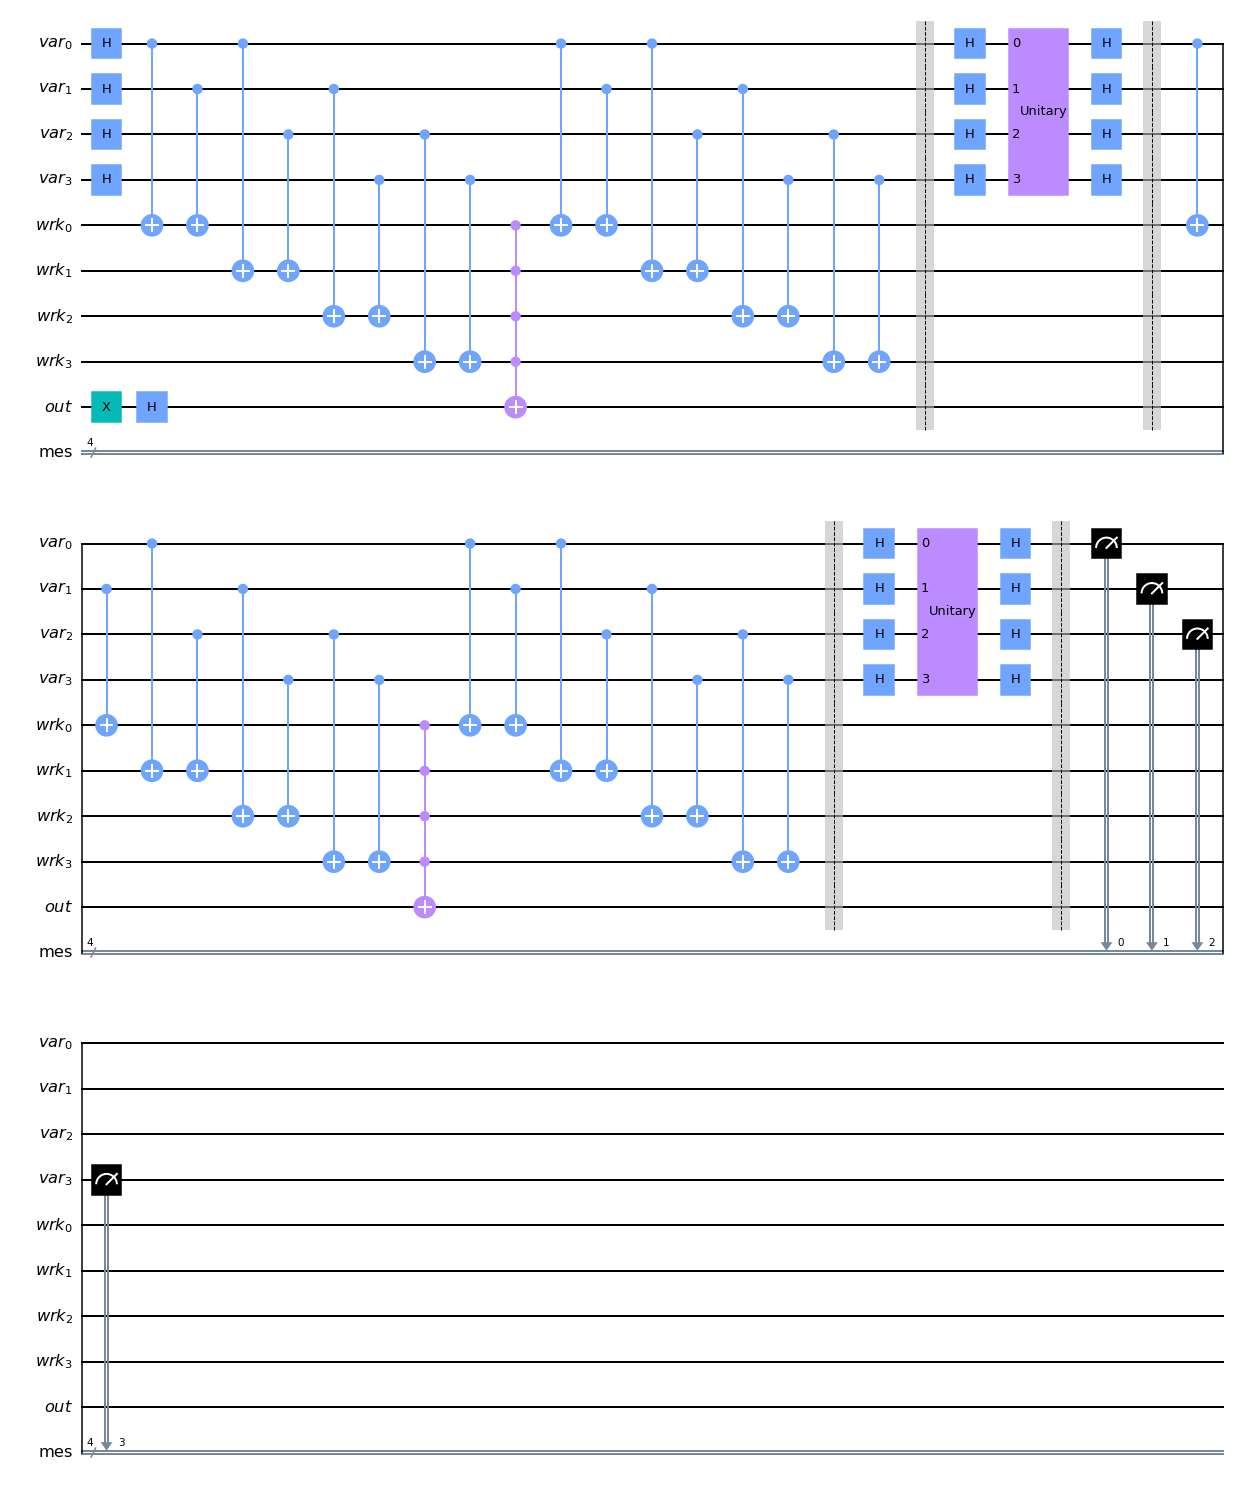

In [50]:
qc=sud2x2()
qc.draw('mpl')

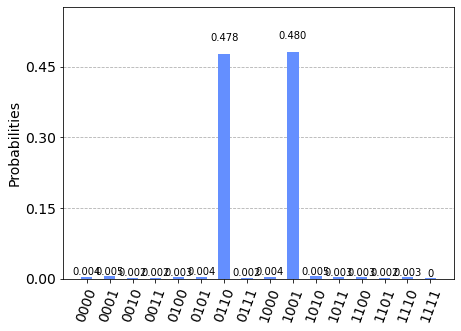

In [51]:
plot_histogram(runAer(qc))

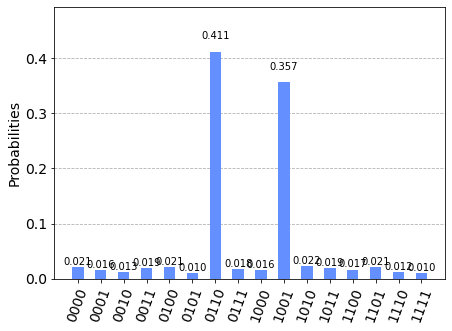

In [52]:
expression = '(x1^x2)&(x1^x3)&(x2^x4)&(x3^x4)'
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
    grover = Grover(quantum_instance=QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024))
    result = grover.amplify(problem)
    display(plot_histogram(result.circuit_results[0]))
except MissingOptionalLibraryError as ex:
    print(ex)

# Sudoku Problem using Adiabatic Quantum Computer

In [53]:
sampler = LeapHybridSampler()

In [75]:

S=[
    [0,0,5,3,0,0,0,0,0],
    [8,0,0,0,0,0,0,2,0],
    [0,7,0,0,0,0,5,0,0],
    [4,0,0,0,0,5,3,0,0],
    [0,1,0,0,7,0,0,0,6],
    [0,0,3,2,0,0,0,8,0],
    [0,6,0,5,0,0,0,0,1],
    [0,0,4,0,0,0,0,3,0],
    [0,0,0,0,0,9,0,0,0]
]

n = len(S)
N=int(math.sqrt(n))
rn = range(n)

def f(i: int,j: int,k: int) -> int:
    return "{}{}{}".format(i,j,k)

In [76]:
Box=list()
InBox=list()
for i in range(N):
    for j in range(N):
        Box.append((i*N,j*N))
        InBox.append((i,j))
print(Box,InBox)

[(0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6), (6, 0), (6, 3), (6, 6)] [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


In [77]:
Q = defaultdict(int)
c=1
        
for i in rn:
    for j in rn:
        for k in rn:
            
            cel1 = f(i,j,k)
            row1 = f(j,k,i)
            col1 = f(k,j,i)
            
            # Hints
            if S[i][j] == k+1:
                Q[(cel1,cel1)]   = -2*c
            else:
                Q[(cel1,cel1)]  = -c

            
            
            for k2 in range(k+1,n):
                
                cel2 = f(i,j,k2)
                row2 = f(j,k2,i)
                col2 = f(k2,j,i)
                
                Q[(cel1,cel2)]  = 2*c
                Q[(row1,row2)]  = 2*c
                Q[(col1,col2)]  = 2*c
            
            # Box number
            i0 = (j // N)*N
            j0 = (k // N)*N
            # Boxes
            for k1 in rn:
                
                i1,j1 = InBox[k1]
                I = i0+i1
                J = j0+j1
                
                box1 = f(I,J,i)
                
                for k2 in range(k1+1,n):
                    
                    i2,j2=InBox[k2]
                    I1 = i0+i2
                    J1 = j0+j2
                    
                    box2 = f(I1,J1,i)
                    Q[(box1,box2)]  = 2*c

In [78]:
# Submit for solution
answer = sampler.sample_qubo(Q)
R = answer.first[0]

Input the solution to a matrix

In [79]:
D = list()
print('Solution')
for i in range(n):
    D_=list()
    for j in range(n):
        for k in range(n):
            if R.get(f(i,j,k))==1:
                print(k+1,end=' ')
                D_.append(k+1)
                break
    D.append(D_)
    print()

Solution
6 2 5 3 9 8 7 1 4 
8 4 9 7 5 1 6 2 3 
3 7 1 6 2 4 5 9 8 
4 8 6 9 1 5 3 7 2 
9 1 2 8 7 3 4 5 6 
7 5 3 2 4 6 1 8 9 
2 6 8 5 3 7 9 4 1 
5 9 4 1 6 2 8 3 7 
1 3 7 4 8 9 2 6 5 


Check if the solution found is a solution for the given problem.

In [80]:
flag=True
for i in range(n):
    for j in range(n):
        if S[i][j]!=0 and S[i][j]!=D[i][j]:
            print('At ({},{}) the solution does not match the question'.format(i,j))
            flag=False
if flag:
    print('The solution found is a solution for the given question')

The solution found is a solution for the given question


Check if the solution found is a valid Sudoku solution.

In [81]:
flag=True
for i in rn:
    for j in rn:
        x=set()
        y=set()
        for k in rn:
            x.add(D[j][k])
            y.add(D[k][j])
        if len(x)!=n:
            flag=False
            print('In {}th row, only {} numbers are present.'.format(j,x))
        if len(x)!=n:
            flag=False
            print('In {}th column, only {} numbers are present.'.format(j,y))
        for k in rn:
            
            i0 = (j // N)*N
            j0 = (k // N)*N
            x=set()
            # Boxes
            for k1 in rn:
                i1,j1 = InBox[k1]
                I = i0+i1
                J = j0+j1
                x.add(D[I][J])
            if len(x)!=n:
                flag=False
                print('In the box ({},{}), only {} numbers are present.'.format(I,J,x))
if flag:
    print('Solution is a valid sudoku')

Solution is a valid sudoku


# Knapsack Problem

sacks is set of integers,
k is the number to equate a subset of sacks with.

In [61]:
sacks = [10, 15, 40,35,20]
k = 50
n=len(sacks)
Q = defaultdict(int)

In [62]:
for i in range(n):
    for j in range(i+1,n):
        Q[(i,j)] = 2*sacks[i]*sacks[j]
    Q[(i,i)] = sacks[i]*(sacks[i]-2*k)

In [63]:
s = EmbeddingComposite(DWaveSampler())
ss = s.sample_qubo(Q,num_reads=100)

In [64]:
for i in range(8):
    x = ss.samples()[i]
    sum=0
    for j in range(n):
        sum += x[j]*sacks[j]
    print(x,'\t',sum)

{0: 0, 1: 1, 2: 0, 3: 1, 4: 0} 	 50
{0: 1, 1: 0, 2: 1, 3: 0, 4: 0} 	 50
{0: 0, 1: 1, 2: 1, 3: 0, 4: 0} 	 55
{0: 1, 1: 1, 2: 0, 3: 0, 4: 1} 	 45
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1} 	 55
{0: 1, 1: 0, 2: 0, 3: 1, 4: 0} 	 45
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0} 	 40
{0: 1, 1: 1, 2: 0, 3: 1, 4: 0} 	 60


The descending order of energy of the state and the sum of the subset is printed above. It is clear that, the farther the state is from the solution, the higher the energy.

# Nijenhuis' Algorithm

In [65]:
# For randomizing Frobenius problem's input
def nums(n=5,r=100):
    out = list()
    l = list(range(2,r))
    gcd = l.pop()
    out.append(gcd)
    while True:
        nl = random.sample(l,n)
        if math.gcd(*nl)==1:
            return nl

In [66]:
A =  [5, 7, 11, 17]
# = nums()
A.sort(reverse=True)
print("A = ",A)
n = len(A)
a0 = A.pop()
g = nx.DiGraph()
g.add_nodes_from(range(a0))

A =  [17, 11, 7, 5]


In [83]:
e = list()
for i in range(a0):
    for x in A:
        if i!=(i+x)%a0:
            e.append((i,(i+x)%a0,x))
g.add_weighted_edges_from(e)
print("Vertices = ",g.nodes())

Vertices =  [0, 1, 2, 3, 4]


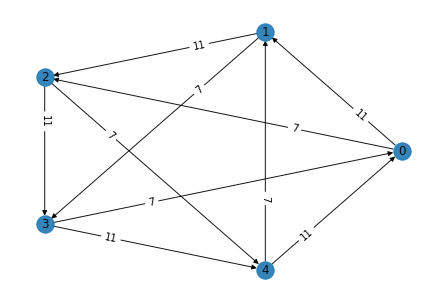

In [84]:
pos=nx.circular_layout(g)
nx.draw(
    g,
    pos,
    alpha=0.9,
    labels={node:node for node in g.nodes()}
)

edge_labels = nx.get_edge_attributes(g,'weight')
x=nx.draw_networkx_edge_labels(g, pos, edge_labels = edge_labels,label_pos=0.7)

In [85]:
adj=nx.adjacency_matrix(g).todense()
print(adj)

[[ 0 11  7  0  0]
 [ 0  0 11  7  0]
 [ 0  0  0 11  7]
 [ 7  0  0  0 11]
 [11  7  0  0  0]]


In [86]:
length, path = nx.single_source_dijkstra(g, 0)
print(length)
print("f(A) = ",max(length.values())-a0)

{0: 0, 2: 7, 1: 11, 4: 14, 3: 18}
f(A) =  13


# Forbenius Problem solution using Adiabatic Quantum Computer

## Edge properties of circulant graph generated by Nijenhuis' algorithm
Here $V=\{0,1,...,a_0-1\}$ \
Let $(j,w) \in B$ ( edge $ 0\rightarrow j$ has weight w ) \
Then $i \rightarrow (i+j)\%a_0$ and $(a_0-j+i)\%a_0 \rightarrow i$  where $i \in V$

In [92]:
# Randomizes input for Frobenius problem
def nums(n=5,r=100):
    out = list()
    l = list(range(2,r))
    gcd = l.pop()
    out.append(gcd)
    while True:
        nl = random.sample(l,n)
        if math.gcd(*nl)==1:
            return nl
# Edge to qbit number encoding
def f(i: int ,j: int) -> int:
    global n
    return n*i+j    
# Takes edge's index in B and the vertex at which it must end is 'i'
# Returns the vertex from which the corresponding edge goes to i
def jtoi(j: int ,i: int) -> int:
    global B
    global a0
    return (a0-B[j][0]+i)%a0

In [93]:
def SPConstraintGen(B: list,c: list,a0: int,i: int,Q: defaultdict,flag: int = 3) -> None:
    # B is list of (j,w)
    # a0 is the smallest of input
    # i is the vertex in consideration
    # Q is the input to DWAVE
    # flag : 1 means i is source
    #        2 means i is destination
    #        3 means i is other vertex
    n=len(B)
    Y = range(n)
    a = 0
    b = 0
    if flag==3:
        a=c[3]
        b=c[3]
    elif flag==1:
        a=-c[1]
        b=3*c[1]
    elif flag==2:
        a=3*c[2]
        b=-c[2]
    else:
        return
    
    for j in Y:
        
        z1=f(i,j)
        
        q1=jtoi(j,i)
        z2=f(q1,j)
        
        Q[(z1,z1)]+=a
        Q[(z2,z2)]+=b
        for k in range(j+1,n):
            q2 = jtoi(k,i)
            # i->k
            z3=f(i,k)
            # k->i
            z4=f(q2,k)
            # i->j i->k
            Q[(z1,z3)]+=2*c[flag]
            # j->i k->i
            Q[(z2,z4)]+=2*c[flag]
        for k in Y:
            q2=jtoi(k,i)
            # k->i
            z4=f(q2,k)
            # i->j k->i
            Q[(z1,z4)]+=-2*c[flag]
            

In [94]:

def QShortestPath(B: list,a0: int,s: int,d: int):
    global A
    Q = defaultdict(int)
    c1= [np.sum(i) for i in zip(*B)][1]*a0
    c=[1,c1,c1,c1]
    X=list(range(a0))
    n=len(B)
    for i in X:
        for j in range(n):
            tmp = f(i,j)
            Q[(tmp,tmp)]=B[j][1]*c[0]
    X.pop(s)
    X.pop(d-1)
    for i in X:
        SPConstraintGen(B=B,c=c,a0=a0,i=i,Q=Q)
    SPConstraintGen(B=B,c=c,a0=a0,i=s,Q=Q,flag=1)
    SPConstraintGen(B=B,c=c,a0=a0,i=d,Q=Q,flag=2)
    s = EmbeddingComposite(DWaveSampler())
    ss = s.sample_qubo(Q,num_reads=999)
    
    O=ss.first[0]
    f1=0
    for i in range(len(B)*a0):
        if O[i]==1:
            f1+=B[i%len(B)][1]
    return f1,ss

In [95]:
def QCirculantDiameter(B: list,a0: int):
    max=0
    l = list()
    for i in range(1,a0):
        t,ss=QShortestPath(B=B,a0=a0,s=0,d=i)
        l.append(ss)
        if t>max:
            max=t
    return max,l

In [96]:
#A=[13,17,19,23,31,37,41,43]
#A=nums()
A=[5,7,11,17]
print('A = ',A)
A.sort(reverse=True)
a0=A.pop()
B=dict()
for x in A:
    i = x%a0
    if i != 0:
        B[i]=x
B=list(B.items())
print(B)
n=len(B)
print('a0 = ',a0)
m,l=QCirculantDiameter(B=B,a0=a0)
print('f(A) = ',m-a0)

A =  [5, 7, 11, 17]
[(2, 7), (1, 11)]
a0 =  5
f(A) =  13


A is the input set. The list after A is B, which contains the general form of edges. $a_0$ is the smallest number in the set A. f(A) is the Frobenius number.